In [1]:
import os
import time
import math
import re
import struct
import traceback
import codecs

import bitstring

import numpy as np
import matplotlib.pyplot as plt
import cv2

from PIL import Image
import IPython.display as display

In [2]:
os.listdir('.')

['.ipynb_checkpoints',
 'ETL9G_01',
 'ETL9G_02',
 'ETL9G_03',
 'ETL9G_04',
 'ETL9G_05',
 'ETL9G_06',
 'ETL9G_07',
 'ETL9G_08',
 'ETL9G_09',
 'ETL9G_10',
 'ETL9G_11',
 'ETL9G_12',
 'ETL9G_13',
 'ETL9G_14',
 'ETL9G_15',
 'ETL9G_16',
 'ETL9G_17',
 'ETL9G_18',
 'ETL9G_19',
 'ETL9G_20',
 'ETL9G_21',
 'ETL9G_22',
 'ETL9G_23',
 'ETL9G_24',
 'ETL9G_25',
 'ETL9G_26',
 'ETL9G_27',
 'ETL9G_28',
 'ETL9G_29',
 'ETL9G_30',
 'ETL9G_31',
 'ETL9G_32',
 'ETL9G_33',
 'ETL9G_34',
 'ETL9G_35',
 'ETL9G_36',
 'ETL9G_37',
 'ETL9G_38',
 'ETL9G_39',
 'ETL9G_40',
 'ETL9G_41',
 'ETL9G_42',
 'ETL9G_43',
 'ETL9G_44',
 'ETL9G_45',
 'ETL9G_46',
 'ETL9G_47',
 'ETL9G_48',
 'ETL9G_49',
 'ETL9G_50',
 'ETL9INFO',
 'etl_9g_inspect_data.ipynb']

In [3]:
file_list = [
    'ETL9G_01',
    'ETL9G_02',
    'ETL9G_03',
    'ETL9G_04',
    'ETL9G_05',
    'ETL9G_06',
    'ETL9G_07',
    'ETL9G_08',
    'ETL9G_09',
    'ETL9G_10',
    'ETL9G_11',
    'ETL9G_12',
    'ETL9G_13',
    'ETL9G_14',
    'ETL9G_15',
    'ETL9G_16',
    'ETL9G_17',
    'ETL9G_18',
    'ETL9G_19',
    'ETL9G_20',
    'ETL9G_21',
    'ETL9G_22',
    'ETL9G_23',
    'ETL9G_24',
    'ETL9G_25',
    'ETL9G_26',
    'ETL9G_27',
    'ETL9G_28',
    'ETL9G_29',
    'ETL9G_30',
    'ETL9G_31',
    'ETL9G_32',
    'ETL9G_33',
    'ETL9G_34',
    'ETL9G_35',
    'ETL9G_36',
    'ETL9G_37',
    'ETL9G_38',
    'ETL9G_39',
    'ETL9G_40',
    'ETL9G_41',
    'ETL9G_42',
    'ETL9G_43',
    'ETL9G_44',
    'ETL9G_45',
    'ETL9G_46',
    'ETL9G_47',
    'ETL9G_48',
    'ETL9G_49',
    'ETL9G_50',
]

In [4]:
filename = file_list[0]
print(filename)
file_stream = bitstring.ConstBitStream(filename=filename)

ETL9G_01


0x3021


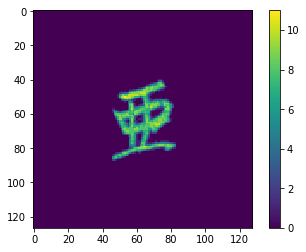

In [5]:
record = file_stream.readlist(','.join([
    'int:16', # Serial Sheet Number - [0]
    'uint:16', # JIS Character Code (JIS X 0208) - [1]
    '8*uint:8', # JIS Typical Reading (e.g. 'AI.MEDER') - [2:10]
    'int:32', # Serial Data Number - [10]
    '4*int:8', # - [11:15]
    '4*uint:16', # - [15:19]
    '2*int:8', # x and y - [19:21]
    'pad:272',
    'bytes:8128', # 16-graylevel (4-bit) image of 128 x 127 = 16256 pixels
    'pad:56',
]))

record_dict = {
    'JIS_CODE': record[1],
    'image_data': record[-1]
}

print(hex(record_dict['JIS_CODE']))

width = 128
height = 127
img = np.array(Image.frombytes('F', (width, height), record_dict['image_data'], 'bit', 4))
plt.imshow(img)
plt.colorbar()

In [6]:
print(type(record), len(record))
for idx, v in enumerate(record[:-1]):
    print(f'{idx} - {v}')

<class 'list'> 22
0 - 1
1 - 12321
2 - 65
3 - 46
4 - 84
5 - 83
6 - 85
7 - 71
8 - 85
9 - 32
10 - 1
11 - 0
12 - 0
13 - 0
14 - 0
15 - 0
16 - 0
17 - 8212
18 - 8310
19 - 0
20 - 0


In [7]:
total_samples = 0
record_count = {}

for filename in file_list:
    file_stream = bitstring.ConstBitStream(filename=filename)

    while True:
        try:
            record = file_stream.readlist(','.join([
                'int:16', # Serial Sheet Number - [0]
                'uint:16', # JIS Character Code (JIS X 0208) - [1]
                '8*uint:8', # JIS Typical Reading (e.g. 'AI.MEDER') - [2:10]
                'int:32', # Serial Data Number - [10]
                '4*int:8', # - [11:15]
                '4*uint:16', # - [15:19]
                '2*int:8', # x and y - [19:21]
                'pad:272',
                'bytes:8128', # 16-graylevel (4-bit) image of 128 x 127 = 16256 pixels
                'pad:56',
            ]))
        except:
            break
        
        total_samples += 1
        record_dict = {
            'JIS_CODE': record[1],
            'image_data': record[-1],
        }
        
        name = hex(record_dict['JIS_CODE'])
        if name in record_count.keys():
            record_count[name] += 1
        else:
            record_count[name] = 1

In [8]:
total_samples

607200

In [9]:
len(record_count.keys())

3036

In [10]:
record_count

{'0x3021': 200,
 '0x3022': 200,
 '0x3023': 200,
 '0x3024': 200,
 '0x3025': 200,
 '0x3026': 200,
 '0x3027': 200,
 '0x3028': 200,
 '0x3029': 200,
 '0x302a': 200,
 '0x302b': 200,
 '0x302c': 200,
 '0x302d': 200,
 '0x302e': 200,
 '0x302f': 200,
 '0x2422': 200,
 '0x3030': 200,
 '0x3031': 200,
 '0x3032': 200,
 '0x3033': 200,
 '0x3034': 200,
 '0x3035': 200,
 '0x3036': 200,
 '0x3037': 200,
 '0x3038': 200,
 '0x3039': 200,
 '0x303a': 200,
 '0x303b': 200,
 '0x303c': 200,
 '0x303d': 200,
 '0x303e': 200,
 '0x2424': 200,
 '0x303f': 200,
 '0x3040': 200,
 '0x3041': 200,
 '0x3042': 200,
 '0x3043': 200,
 '0x3044': 200,
 '0x3045': 200,
 '0x3046': 200,
 '0x3047': 200,
 '0x3048': 200,
 '0x3049': 200,
 '0x304a': 200,
 '0x304b': 200,
 '0x304c': 200,
 '0x304d': 200,
 '0x2426': 200,
 '0x304e': 200,
 '0x304f': 200,
 '0x3050': 200,
 '0x3051': 200,
 '0x3052': 200,
 '0x3053': 200,
 '0x3054': 200,
 '0x3055': 200,
 '0x3056': 200,
 '0x3057': 200,
 '0x3058': 200,
 '0x3059': 200,
 '0x305a': 200,
 '0x305b': 200,
 '0x305c